# **TOPIC EXTRACTION using SVD, CLUSTERING/GMM**


---
**ANALYZING TWITTER POSTS**


Considering **Xbox** and **PlayStation** brands, we aim to extract main topics discussed on Twitter during two main important events for those brands: the launch of the new consoles *Xbox Series X* and *PS5* in November 2020, and the launch of *Xbox One X* in November 2017.

We analyze the temporal windows and the datasets separately. 

The analysis is based on the following approach:

- we filter tweets by language
- we search for the best `vectorization` to deal with the "dirty nature" of Twitter (i.e. setting min_df and max_df, customizing stop words,...)
- we reduce the dimensionality of the data using `TruncatedSVD`, to improve Clustering efficiency
- we approach *soft clustering* using` Gaussian Mixture Models`
- we approach *hard clustering* using `K-Means++`
- we try to extract *local topics* for each cluster using `Latent Dirichlet Allocation`
- we analyze clusters and topics using many useful visualizations (WordCloud, timeseries tweet count, timeseries sentiment count,...)
- we analyze the sentiment of clusters using the score obtained with `VADER`
- finally, we approach Hierarchical Clustering with `linkage` algorithm, just to understand the hierarchical structure and complexity of our dataset.

# Importing libraries

In [1]:
import re
import sys
from google.colab import drive
import time
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn import metrics
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.metrics import pairwise_distances_argmin_min
from scipy.spatial.distance import cdist 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import wordcloud
from wordcloud import WordCloud
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import matplotlib
from datetime import timedelta
import datetime
from scipy.cluster import hierarchy

# Mount drive

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#Set parameters
- `path` path to the project folder, \
  **please check that is correct !**

- `using_hashtag` if true will be used tweets including hashtags and tags otherwise they will be removed.

- `using_dataset` contains the name of the dataset we want to analyze, between xbox one, xbox series, ps4, ps5.

- `using_custom_stopword` if true remove common words according to the dataset chosen.

- `which_sentiment` if not None tweets are filtered according to the sentiment analysis applied during preprocessing

- `LANGUAGE` identify the language of reviews

- `selected_clusters` is a parameters to choose a customize value for clusters, if set to None will be search the best number using K means or GMM

- `model_clusters` is a parameter to choose which method will be used for finding best cluster number. It can be set to GMM or KM respectively for gaussian mixture model and k means. If `selected_clusters` is not None this parameter will be used just to compute the model using `selected_clusters` as parameter.
Note: we highly suggest to use K means as model for clustering as Gaussian Mixture Model has been added to strengthen our results during experimentations

In [3]:
## General path
# Change this path according to where the data project's folder is located
path = '/content/drive/MyDrive/Project_Data_Mining/Data/'

# If you want to use tweets that contains hashtags and tags or not
using_hashtag = True

## Choosing a dataset to analyze
# 0 -> playstation 2017/2018
# 1 -> playstation 2020/2021
# 2 -> xbox 2017/2018
# 3 -> xbox 2020/2021
which_dataset = 3

# Remove customize stopwords in addiction to the english one
using_custom_stopword = True

## Choose which tweets you want to use:
# -1 -> Negative
# 0 -> Neutral (questions)
# 1 -> Positive
# None -> All tweets
which_sentiment = None

## Choose a language
# english        62942 tweets
# french           223 tweets
# spanish          144 tweets
# german            95 tweets
# italian           70 tweets
LANGUAGE = 'english'

# Choose custom number of clusters
selected_clusters = 5

## Choose which model you want to use for clustering
# GMM -> Gaussian Mixture Model
# KM -> K means
model_clusters = 'KM'

# Choose the number of topic to extract from each cluster
N_TOPICS = 2

# check that model_clusters is correctly selected
if model_clusters not in ['GMM', 'KM']: raise AssertionError('model_clusters must be choose between GMM and KM')

## Loading dataset

In [4]:
# Set global seed
SEED = 42 # The Answer to the Ultimate Question of Life, The Universe, and Everything. -> <3
np.random.seed(SEED)

dataset_product = ['playstation17', 'playstation20', 'xbox17', 'xbox20']
using_dataset = dataset_product[which_dataset]

# Set of customize stopwords
custom_stopwords = {'game','#game', '#videogam','#gamer', 'seri'}

 #topics that we will define for each cluster
if using_dataset == 'playstation17': N_TOP_WORDS = 38
else: N_TOP_WORDS = 40

# Set preorder and publish date of products
if using_dataset == 'xbox20': 
  preorder_date = '20200922'
  published_date = '20201110'
elif using_dataset == 'playstation20':
  preorder_date = '20200922'
  published_date = '20201112'
else: 
  preorder_date = None 
  published_date = None 

# Defining sub paths  
data_folder= path + 'Project_Data_Mining/Data/'
amazon_folder = data_folder + 'Amazon/preprocessed_dataset/'
amazon_folder_original = data_folder + 'Amazon/clean_dataset/'

##  XBOX FROM 2020 TO 2021 
if using_dataset == 'xbox20': 
  dataset_file = 'xbox_2020-09-22_2021-02-02_tweets'
  tot_file = 8

##  XBOX FROM 2017 TO 2018
elif using_dataset == 'xbox17':
  dataset_file = 'xbox_2017-09-22_2018-02-02_tweets'
  tot_file = 1

##  PLAYSTATION FROM 2020 TO 2021
elif using_dataset == 'playstation20':
  dataset_file = 'playstation_2020-09-22_2021-02-02_tweets'
  tot_file = 6

##  PLAYSTATION FROM 2017 TO 2018
else:
  dataset_file = 'playstation_2017-09-22_2018-02-02_tweets'
  tot_file = 1

#Loading the TWITTER dataset [preprocessed]
twitter_folder = path + 'Twitter/preprocessed_dataset/'
if tot_file > 1:
  t_df = pd.read_csv(twitter_folder + 'preprocessed_' + dataset_file +'1.csv')
  for i in range(1,tot_file + 1):
    df = pd.read_csv(twitter_folder + 'preprocessed_' + dataset_file + str(i) + '.csv') 
    t_df = t_df.append(df)
else: t_df = pd.read_csv(twitter_folder + 'preprocessed_' + dataset_file +'.csv') 


#Loading the TWITTER dataset [not preprocessed]
twitter_folder_original = path + 'Twitter/clean_dataset/'
if tot_file > 1:
  t_original_df = pd.read_csv(twitter_folder_original + 'clean_' + dataset_file +'1.csv') 
  for i in range(1,tot_file + 1):
    df = pd.read_csv(twitter_folder_original + 'clean_' + dataset_file + str(i) + '.csv') 
    t_original_df = t_original_df.append(df)
else: t_original_df = pd.read_csv(twitter_folder_original + 'clean_' + dataset_file +'.csv') 


print('\n\n---- TWITTER DATASET : ', using_dataset, ' ----')
print('Loaded ', t_df['tweet_text'].count(), ' preprocessed tweets and ', 
      t_original_df['tweet_text'].count(), ' cleaned tweets.')
first_date = str(t_df['datatime'].min())
last_date = str(t_df['datatime'].max())
print('Tweets from ', first_date[-2:]+'/'+first_date[4:6]+'/'+first_date[0:4], ' to ', \
      last_date[-2:]+'/'+last_date[4:6]+'/'+last_date[0:4])
print('Columns : ', list(t_df.columns))



---- TWITTER DATASET :  xbox20  ----
Loaded  34054  preprocessed tweets and  34054  cleaned tweets.
Tweets from  22/09/2020  to  01/02/2021
Columns :  ['username', 'datatime', 'tweet_text', 'retweeted_text', 'likes', 'retweets', 'comments', 'language', 'is a question', 'tweet wout hashtag', 'retweet wout hashtag', 'sentiment analysis']


Concatenate tweet text and retweet text to better contextualize a tweet that retweeted something.

In [5]:
if using_hashtag: t_df['full_text'] = t_df['tweet_text'] + t_df['retweeted_text'].fillna('')
else: t_df['full_text_wout_hashtag'] = t_df['tweet wout hashtag'] + t_df['retweet wout hashtag'].fillna('')
t_df.head()

,username,datatime,tweet_text,retweeted_text,likes,retweets,comments,language,is a question,tweet wout hashtag,retweet wout hashtag,sentiment analysis,full_text
0,Desbee Jr.,20210201,my first #darkmatterultra clip good 5 #quadfe ...,NaN,3,1,0,english,False,my first clip good 5,NaN,1,my first #darkmatterultra clip good 5 #quadfe ...
1,xboxnintendo222,20210201,no photo mode no cutscen in game bro i xbox #x...,NaN,5,1,1,english,False,no photo mode no cutscen in game bro i xbox ...,NaN,-1,no photo mode no cutscen in game bro i xbox #x...
2,Germanicus,20210201,done #ps5 #xboxseriesx #xboxseri #soni #xbox,NaN,1,2,0,english,False,done,NaN,-1,done #ps5 #xboxseriesx #xboxseri #soni #xbox
3,( FoAm ) XxDaddyxX,20210201,xbox thursday night foam pm est battlefield v ...,NaN,0,0,0,english,False,xbox thursday night foam pm est battlefield v ...,NaN,-1,xbox thursday night foam pm est battlefield v ...
4,David Ross,20210201,man day nightmar the wifi adapt 360 tend terri...,neoneo @neogamesparkfeb 1ah man i rememb day x...,0,0,0,english,False,man day nightmar the wifi adapt 360 tend terri...,neoneo 1ah man i rememb day xbox built wifi 2...,-1,man day nightmar the wifi adapt 360 tend terri...


# Exploratory Data Analysis

## Some general statistic about data

In [6]:
t_df.describe()

,datatime,likes,retweets,comments,sentiment analysis
count,3.405400e+04,34054.000000,34054.000000,34054.000000,34054.000000
mean,2.020339e+07,10.655488,1.985905,1.029512,-0.041581
std,3.933096e+03,113.483633,17.093344,7.052840,0.943989
min,2.020092e+07,0.000000,0.000000,0.000000,-1.000000
25%,2.020110e+07,0.000000,0.000000,0.000000,-1.000000
50%,2.020112e+07,1.000000,1.000000,0.000000,0.000000
75%,2.021010e+07,3.000000,2.000000,1.000000,1.000000
max,2.021020e+07,10004.000000,1701.000000,447.000000,1.000000


**Language of reviews** \
Considering different languages when doing Topic Modeling can introduce noise in the data and confuse the model, so we prefer to separately consider languages. \
We choose to use most common languages that are English and Spanish. \
Note that by changing parameter `LANGUAGE` you can filter the dataset using just `LANGUAGE` samples

Overview of different languages on the dataset

In [7]:
t_df['language'].value_counts()

english     33442
french        119
spanish        75
german         49
italian        36
            ...  
zulu            1
chichewa        1
estonian        1
javanese        1
xhosa           1
Name: language, Length: 62, dtype: int64

Filtering the dataset according to the `LANGUAGE` parameter

In [8]:
t_df = t_df.loc[t_df['language'] == LANGUAGE]
t_original_df = t_original_df.loc[t_original_df['language'] == LANGUAGE]
t_df.head()

,username,datatime,tweet_text,retweeted_text,likes,retweets,comments,language,is a question,tweet wout hashtag,retweet wout hashtag,sentiment analysis,full_text
0,Desbee Jr.,20210201,my first #darkmatterultra clip good 5 #quadfe ...,NaN,3,1,0,english,False,my first clip good 5,NaN,1,my first #darkmatterultra clip good 5 #quadfe ...
1,xboxnintendo222,20210201,no photo mode no cutscen in game bro i xbox #x...,NaN,5,1,1,english,False,no photo mode no cutscen in game bro i xbox ...,NaN,-1,no photo mode no cutscen in game bro i xbox #x...
2,Germanicus,20210201,done #ps5 #xboxseriesx #xboxseri #soni #xbox,NaN,1,2,0,english,False,done,NaN,-1,done #ps5 #xboxseriesx #xboxseri #soni #xbox
3,( FoAm ) XxDaddyxX,20210201,xbox thursday night foam pm est battlefield v ...,NaN,0,0,0,english,False,xbox thursday night foam pm est battlefield v ...,NaN,-1,xbox thursday night foam pm est battlefield v ...
4,David Ross,20210201,man day nightmar the wifi adapt 360 tend terri...,neoneo @neogamesparkfeb 1ah man i rememb day x...,0,0,0,english,False,man day nightmar the wifi adapt 360 tend terri...,neoneo 1ah man i rememb day xbox built wifi 2...,-1,man day nightmar the wifi adapt 360 tend terri...


## Plots

plotting the number of reviews for each day, note that if `preorder_date` and `publish_date` are defined then you'll see them in the plot figure colored differently

<Figure size 432x288 with 0 Axes>

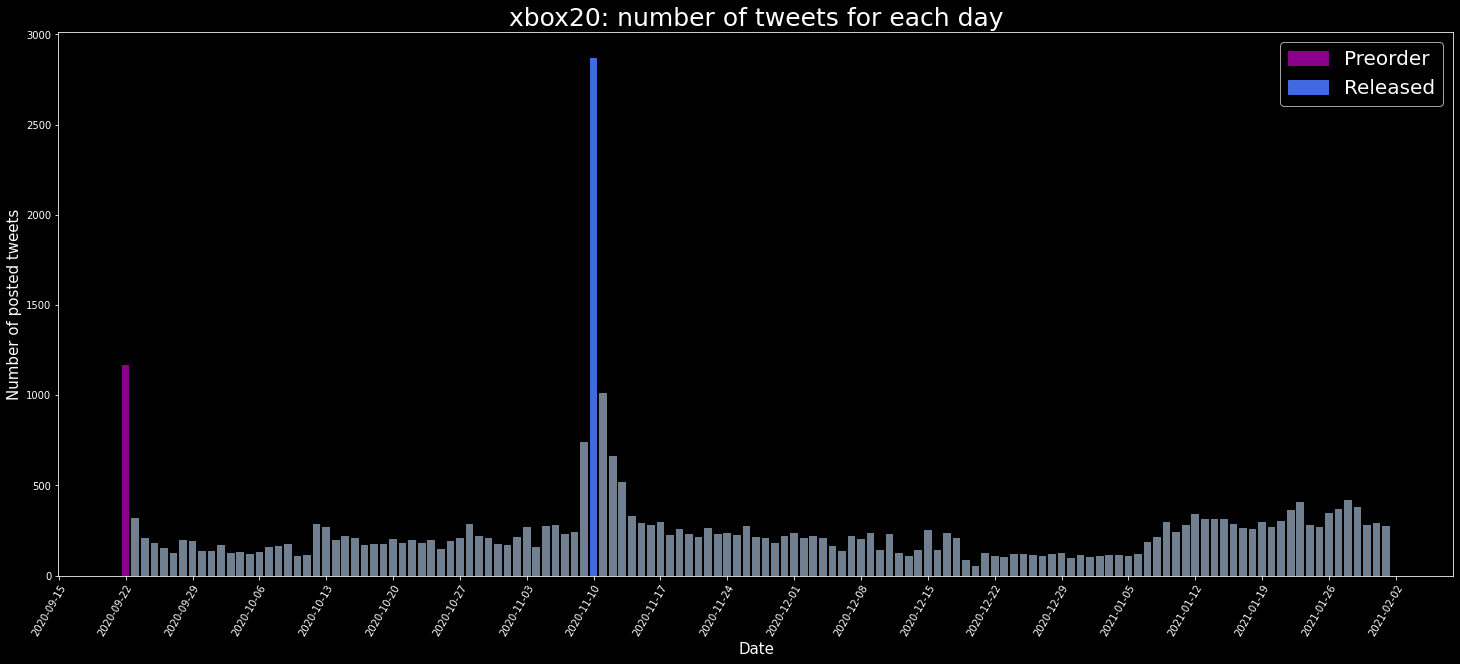

In [9]:
def create_dict_color(preorder_date = None, publish_date = None):
    dict_color = {}
    if preorder_date: dict_color[preorder_date] = 'darkmagenta'
    if publish_date: dict_color[publish_date] = 'royalblue'
    return dict_color

def print_time_series(df_datatime, preorder, published, additional_text = None):
  new_df = pd.DataFrame(df_datatime.apply(lambda x:str(x)).value_counts())
  new_df.reset_index(inplace=True)
  new_df = new_df.rename(columns = {'datatime':'count', 'index':'datatime'}).sort_values('datatime')
  color_map = create_dict_color(preorder, published)
  clrs = [color_map.get(x,'slategray') for x in new_df.datatime]
  new_df.datatime = pd.to_datetime(new_df.datatime)
  plt.figure()
  plt.style.use('dark_background')
  fig, ax = plt.subplots(figsize=(25,10))
  ax.bar(new_df.datatime, new_df['count'], color=clrs)
  # Define the date format
  date_form = DateFormatter("%Y-%m-%d")
  ax.xaxis.set_major_formatter(date_form)
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
  # Set title and labels for axes
  if additional_text: ax.set_title(additional_text+': number of tweets for each day', fontsize=25)
  else: ax.set_title('Number of tweets for each day', fontsize=25)
  if preorder and published:
    custom_legend = []
    if 'darkmagenta' in clrs: custom_legend.append(mpatches.Patch(color='darkmagenta', label='Preorder'))
    if 'royalblue' in clrs: custom_legend.append(mpatches.Patch(color='royalblue', label='Released'))
    ax.legend(handles = custom_legend, loc="upper right", fancybox = True, fontsize = 20)
  ax.set_xlabel("Date", fontsize=15)
  ax.set_ylabel("Number of posted tweets", fontsize=15)
  plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")
  plt.show()

# print time series for dataset
print_time_series(t_df['datatime'], preorder_date, published_date, using_dataset)

Plotting average sentiment during time

2870


<Figure size 432x288 with 0 Axes>

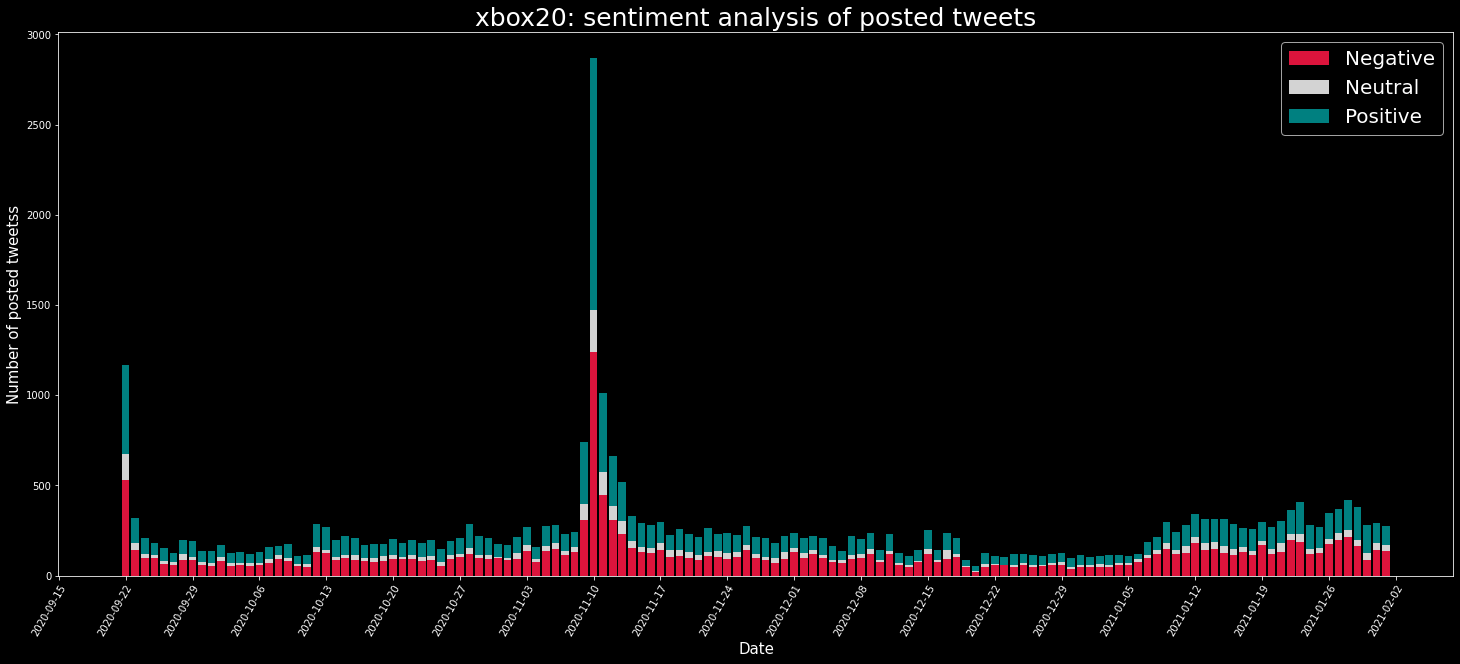

In [10]:
def complete_series(series, datas):
  for i in datas:
    if i not in series.index:
      series[i] = 0
  return series

def plot_average_sentiment(df_sa, additional_text = None):
  df_sa = pd.DataFrame(df_sa).rename(columns = {'sentiment analysis':'count'})
  df_sa.reset_index(inplace=True)
  df_sa.datatime = pd.to_datetime(df_sa.datatime.apply(lambda x:str(x)))
  plt.figure()
  plt.style.use('dark_background')
  fig, ax = plt.subplots(figsize=(25,10))
  new_colors = [plt.get_cmap('jet')(1. * i/3) for i in range(5)]
  new_colors.sort(reverse = True)
  y_0 = df_sa.loc[df_sa['sentiment analysis'] == -1].groupby(['datatime'])['count'].sum()
  y_0 = complete_series(y_0,list(df_sa.datatime.unique()))
  y_1 = df_sa.loc[df_sa['sentiment analysis'] <= 0].groupby(['datatime'])['count'].sum()
  y_1 = complete_series(y_1,list(df_sa.datatime.unique()))
  dict_color_label_start = { -1: ['Negative', 'crimson', None],
                      0: ['Neutral','lightgray', y_0],
                      1: ['Positive','teal', y_1]
  }
  for i in dict_color_label_start.keys():
    y = df_sa.loc[df_sa['sentiment analysis'] == i].groupby(['datatime'])['count'].sum()
    y = complete_series(y,list(df_sa.datatime.unique()))
    ax.bar(df_sa.datatime.unique(), y, color=dict_color_label_start[i][1], label=dict_color_label_start[i][0], \
          bottom = dict_color_label_start[i][2])
    
  print(max(df_sa.groupby(['datatime'])['count'].sum()))
  # Define the date format
  date_form = DateFormatter("%Y-%m-%d")
  ax.xaxis.set_major_formatter(date_form)
  ax.xaxis.set_major_locator(mdates.WeekdayLocator(interval=1))
  # Set title and labels for axes
  if additional_text: ax.set_title(additional_text+': sentiment analysis of posted tweets', fontsize=25)
  else: ax.set_title('Sentiment analysis of posted tweets', fontsize=25)
  ax.set_xlabel("Date", fontsize=15)
  ax.set_ylabel("Number of posted tweetss", fontsize=15)
  plt.setp(ax.get_xticklabels(), rotation=60, ha="right", rotation_mode="anchor")
  plt.legend(loc="upper right",fancybox = True, fontsize = 20)
  plt.show()

if '20' in using_dataset: plot_average_sentiment(t_df.groupby(['datatime','sentiment analysis'])['sentiment analysis'].count(), using_dataset)

# SVD + Clustering

## Vectorization

Vectorize the dataset with `TfIdfVectorizer`

In [11]:
start_time = time.time()
try:
    stopword_set = set(stopwords.words('english'))
    pass
except LookupError:
    nltk.download('stopwords')
    stopword_set = set(stopwords.words('english'))
    pass 

if using_custom_stopword: 
  stopword_set = stopword_set.union(custom_stopwords)
  if using_hashtag:
    if 'xbox' in using_dataset: t_df['full_text'] = t_df['full_text'].apply(lambda x: re.sub(r'[\w|#|@]*box[\w]*', '', x))
    else: 
      t_df['full_text'] = t_df['full_text'].apply(lambda x: re.sub(r'[\w|#|@]*playstat[\w]*', '', x))
      t_df['full_text'] = t_df['full_text'].apply(lambda x: re.sub(r'[\w|#|@]*ps[\w]*', '', x))
  else:
    if 'xbox' in using_dataset: t_df['full_text_wout_hashtag'] = t_df['full_text_wout_hashtag'].apply(lambda x: re.sub(r'[\w|#|@]*box[\w]*', '', x))
    else: 
      t_df['full_text_wout_hashtag'] = t_df['full_text_wout_hashtag'].apply(lambda x: re.sub(r'[\w|#|@]*playstat[\w]*', '', x))
      t_df['full_text_wout_hashtag'] = t_df['full_text_wout_hashtag'].apply(lambda x: re.sub(r'[\w|#|@]*ps[\w]*', '', x))

if 'xbox' in using_dataset:
  if '17' in using_dataset: vec = TfidfVectorizer(min_df=20, max_df = 1.0, token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+', stop_words = stopword_set)  #mantain # and @, no ngrams
  else: vec = TfidfVectorizer(min_df=200, max_df = 9000, token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+', stop_words = stopword_set)  #mantain # and @, no ngrams
else:
  vec = TfidfVectorizer(min_df=100, max_df = 9000, token_pattern=r'\b\w\w+\b|(?<!\w)@\w+|(?<!\w)#\w+', stop_words = stopword_set)  #mantain # and @, no ngrams

if which_sentiment: t_df = t_df.loc[t_df['sentiment analysis'] == which_sentiment]
if using_hashtag: X = vec.fit_transform(t_df['full_text'])
else: X = vec.fit_transform(t_df['full_text_wout_hashtag'])
end_time = time.time()
print("\n", X.shape[0], " documents vectorized, ", X.shape[1], " features extracted in ", end_time-start_time, " seconds.")
print("Here's an example: ", X[0])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

 33442  documents vectorized,  342  features extracted in  1.3935706615447998  seconds.
Here's an example:    (0, 43)	0.35849281669083516
  (0, 53)	0.21858082574878596
  (0, 52)	0.288616177142122
  (0, 8)	0.32752919425711907
  (0, 15)	0.42463887769427455
  (0, 180)	0.3445169516190988
  (0, 118)	0.4580977779332221
  (0, 161)	0.3525152076825545


## Analysis on most frequent words

              0
play       8979
go         6770
#ps        6516
ps5        5855
us         5588
...         ...
absolut     212
upgrad      211
#retrogam   205
chanc       204
#gamestop   202

[342 rows x 1 columns]


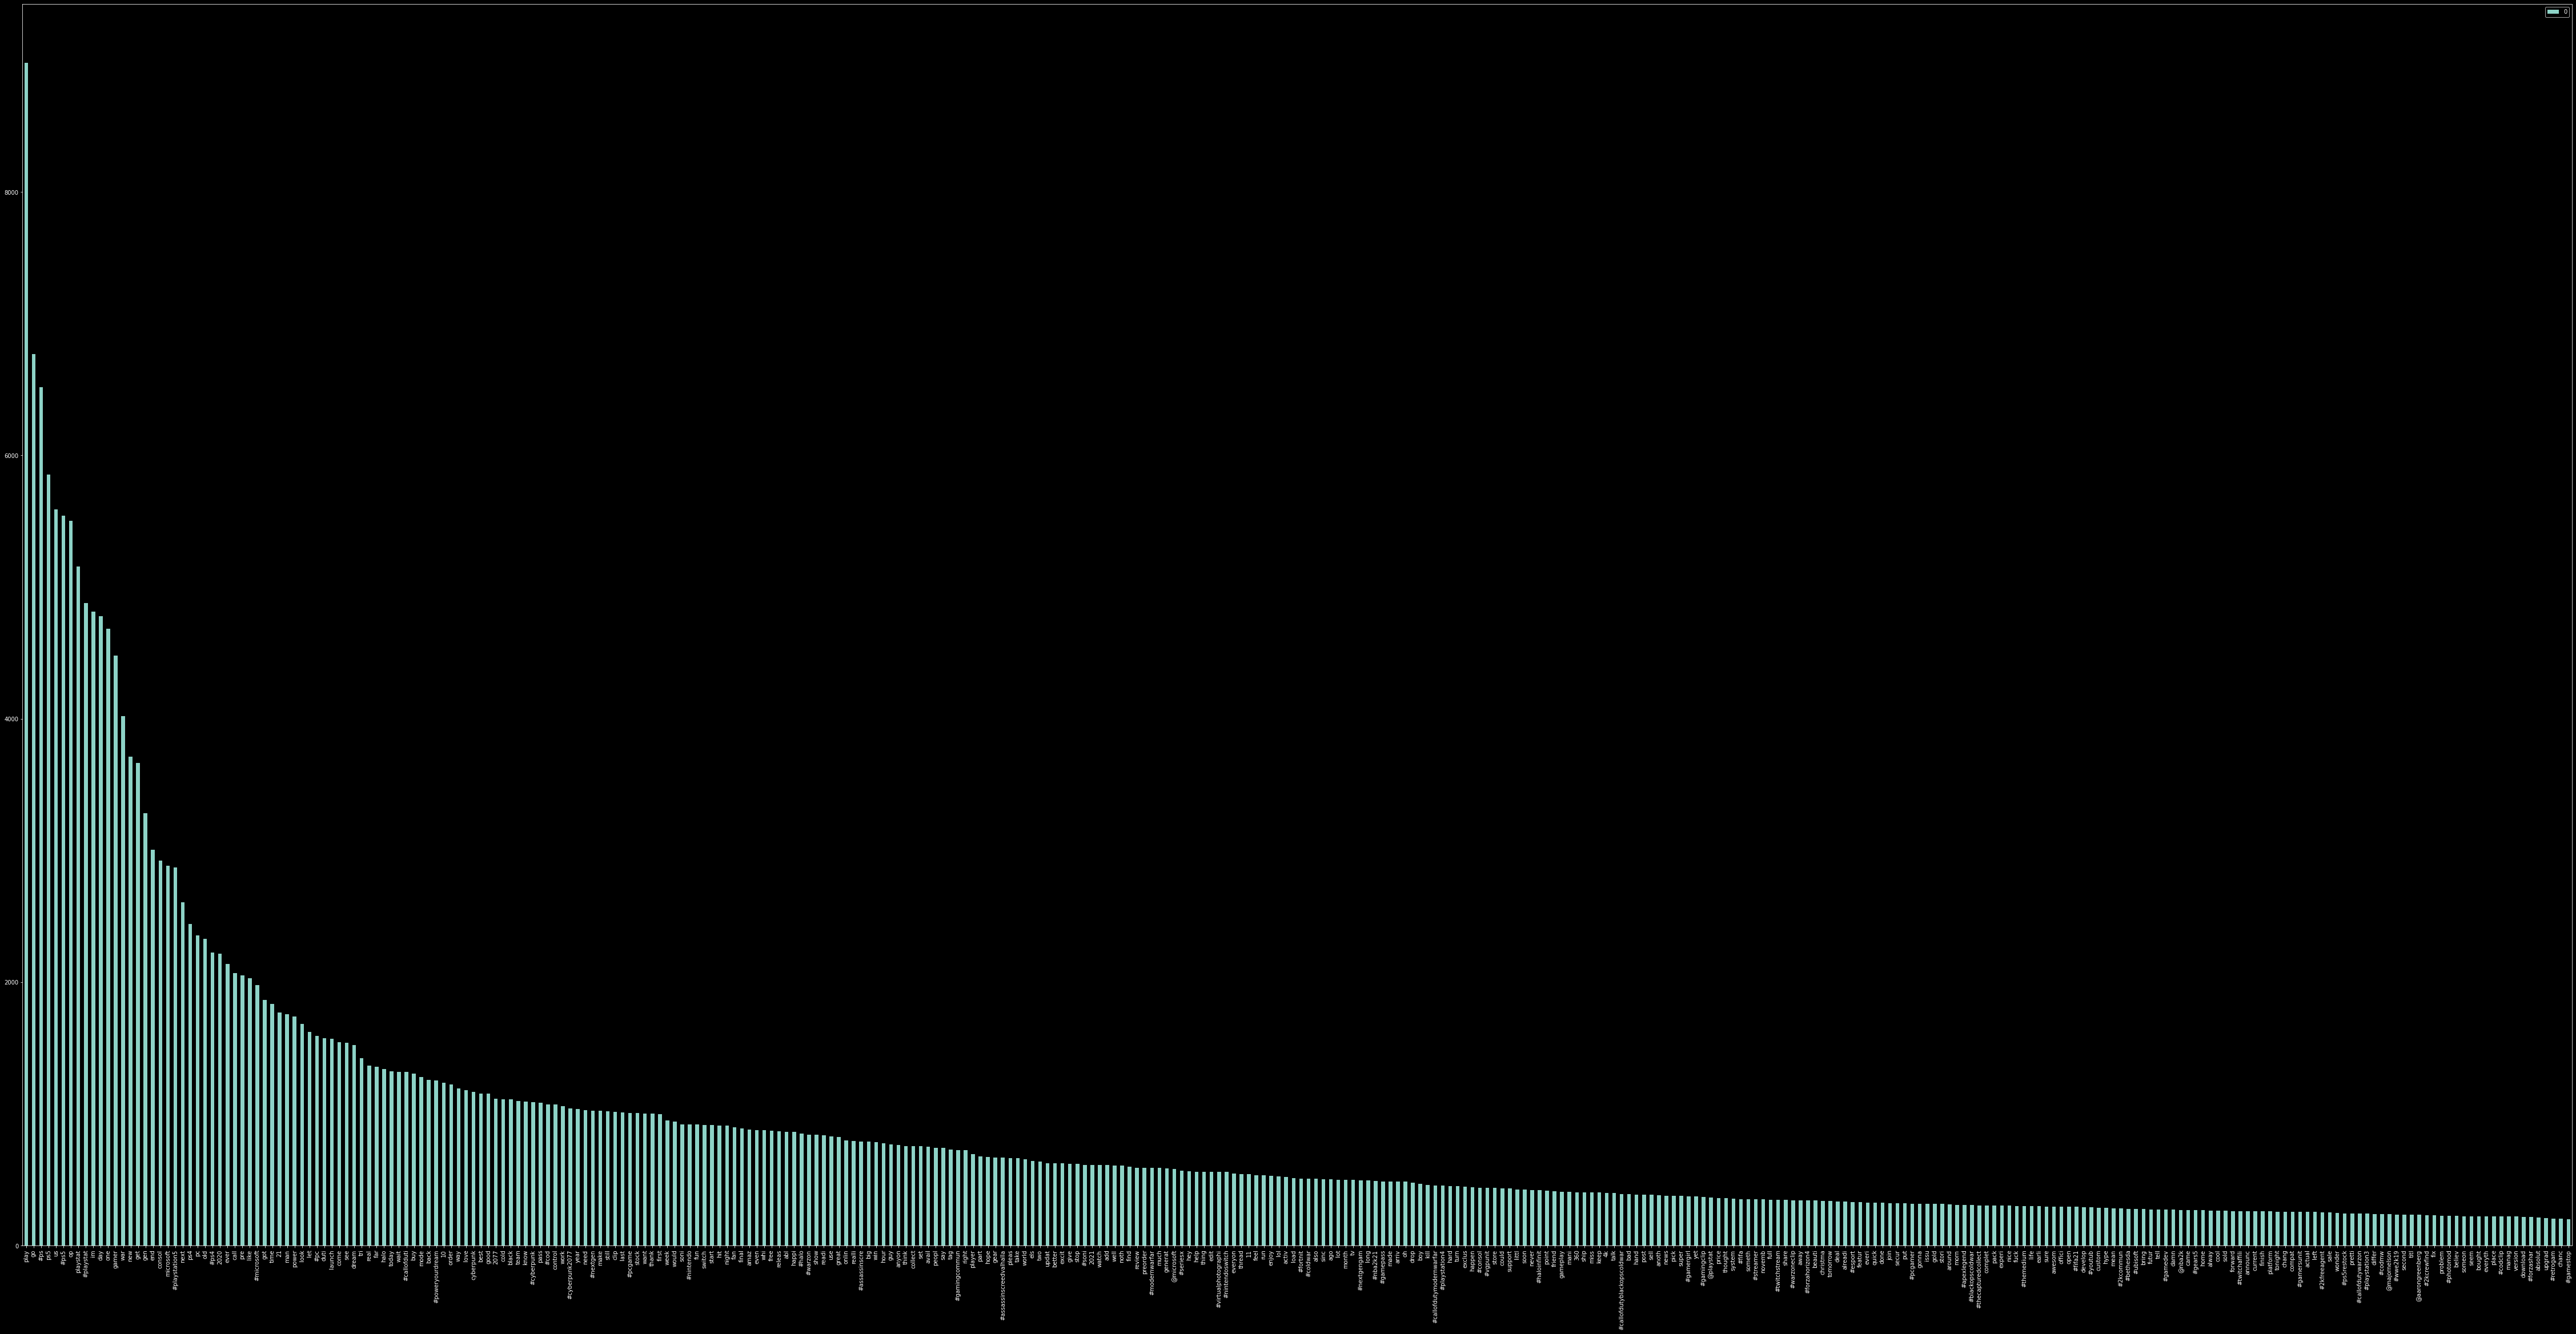

In [12]:
dizionario = dict()                   # O(n*m)
for word in vec.get_feature_names():
  counter=0
  for tweet in t_df['full_text']:
    if word in tweet: counter +=1
  dizionario[word] = counter

dizionario = dict(sorted(dizionario.items(), key=lambda item: item[1], reverse=True))
data_df = pd.DataFrame.from_dict(dizionario, orient = 'index')
print(data_df)
data_df.plot(kind = 'bar', figsize=(80,40))

## Dimensionality reduction

> Dimensionality reduction using truncated SVD (aka LSA).

> This transformer performs linear dimensionality reduction by means of truncated singular value decomposition (SVD). Contrary to PCA, this estimator does not center the data before computing the singular value decomposition. This means **it can work with sparse matrices efficiently**.

> In particular, truncated SVD works on term count/tf-idf matrices as returned by the vectorizers in sklearn.feature_extraction.text. In that context, it is known as latent semantic analysis (LSA).



Dimensionality Reduction with Truncated SVD. 

*How to choose the optimal number of components?*  We need to capture enough variance

In [13]:
k = 9
print("Decomposing the corpus with SVD. . .")
t0 = time.time()
svd = TruncatedSVD(k)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
X_svd = lsa.fit_transform(X)
print("Decomposition ended in %f seconds" % (time.time() - t0))
print(svd.explained_variance_ratio_)  #amount of variance introduced by each component
total_variance = 0.0
for var in svd.explained_variance_ratio_:
  total_variance += var
print("Total variance:", total_variance)

Decomposing the corpus with SVD. . .
Decomposition ended in 0.243429 seconds
[0.01038441 0.01679363 0.01212687 0.01168056 0.0108941  0.0109415
 0.01070726 0.01026613 0.00987478]
Total variance: 0.10366923841773443


## Elbow method

###GAUSSIAN MIXTURE MODEL++

Computing Optimal number of clusters for gaussian modelling with Elbow method.

*Is there a relation between the number of SVD components and the optimal number of clusters according to Silhouette score?*

In [14]:
def elbow(dataframe, max_k):
  plt.style.use('dark_background')
  # The optimal number of clusters (K) is the value that minimizes the Akaike information criterion (AIC) or the Bayesian information criterion (BIC).
  AIC_measure = [] # AIC estimates the quality of each model, relative to each of the other models. Thus, AIC provides a means for model selection.
  BIC_measure = [] # This criterion gives us an estimation on how much is good the GMM in terms of predicting the data we actually have
  models = []
  K = range(2,max_k) 
  for k in K: 
    #Building and fitting the model 
    t0 = time.time()
    gaussianModel = GaussianMixture(n_components=k, max_iter=1000,random_state=SEED)
    gaussianModel.fit(dataframe)    
    t_ = time.time() - t0
    
    models.append(gaussianModel)
    AIC_measure.append(gaussianModel.aic(dataframe))
    BIC_measure.append(gaussianModel.bic(dataframe))
    print("Time needed to compute ", k, " components: ", t_)

  print('\n\n')
  plt.plot(K, AIC_measure, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel('AIC score') 
  plt.title('The Elbow Method using AIC') 
  plt.show() 

  plt.plot(K, BIC_measure, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel('BIC score') 
  plt.title('The Elbow Method using BIC') 
  plt.show() 

  grad = np.gradient(BIC_measure)

  plt.plot(K, grad, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel('gradient of BIC score') 
  plt.title('Gradient of BIC') 
  plt.show() 

  return models,AIC_measure,BIC_measure, grad

def GMM_sum_up(k,model):
  for i in range(k):
    print("the mean vector of the " + str(i)+"° guassian is:")
    print(model.means_[i])
    print("-------------------------------------------------------")
    print("the covariance vector of the " + str(i)+"° guassian is:")
    print(model.covariances_[i])
    ("-------------------------------------------------------")

if model_clusters == 'GMM':
  if not selected_clusters:
      models, AIC, BIC, grad_BIC = elbow(X_svd,10)
      print('\n\n')
      # we have tested all dataset and we have seen that more or less 5 is the optimal number
      # of clusters then we will set it equal to 5
      selected_clusters = 5
      model = models[k-2]
      GMM_sum_up(selected_clusters, model)
  else:
      model = GaussianMixture(n_components=selected_clusters, max_iter=1000, random_state=SEED).fit(X_svd)
      GMM_sum_up(selected_clusters, model)
  # Adding a column to full dataframe with cluster labels
  t_df['cluster'] = model.predict(X_svd)

### K-MEANS++

Computing Optimal number of clusters for K-Means with Elbow method.

*Is there a relation between the number of SVD components and the optimal number of clusters according to Silhouette score?*

In [15]:
#X is a dataframe
def elbow(dataframe, max_k):
  plt.style.use('dark_background')
  distortions = [] 
  inertias = [] 
  silhouette = []
  models = []
  mapping1 = {} 
  mapping2 = {} 
  mapping3 = {}
  K = range(2,max_k) 
  
  for k in K: 
    #Building and fitting the model 
    t0 = time.time()
    kmeanModel = KMeans(n_clusters=k, init='k-means++', max_iter=1000, random_state=SEED)
    kmeanModel.fit(dataframe)     
    t_ = time.time() - t0
    
    models.append(kmeanModel)
    distortions.append(sum(np.min(cdist(dataframe, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / dataframe.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
    silhouette.append(silhouette_score(dataframe, kmeanModel.labels_))
  
    mapping1[k] = sum(np.min(cdist(dataframe, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / dataframe.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 
    mapping3[k] = silhouette_score(dataframe, kmeanModel.labels_)

    print("Time needed to compute ", k, " clusters: ", t_)

  for key,val in mapping1.items(): 
    print(str(key)+' : '+str(val)) 

  plt.plot(K, distortions, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel('Distortion') 
  plt.title('The Elbow Method using Distortion') 
  plt.axis(xmin=0, ymin=0)
  plt.show() 

  for key,val in mapping2.items(): 
    print(str(key)+' : '+str(val)) 

  plt.plot(K, inertias, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel('Inertia') 
  plt.title('The Elbow Method using Inertia') 
  plt.axis(xmin=0, ymin=0)
  plt.show() 

  for key,val in mapping3.items(): 
    print(str(key)+' : '+str(val)) 

  plt.plot(K, silhouette, 'bx-') 
  plt.xlabel('Values of K') 
  plt.ylabel('Silhouette') 
  plt.title('Silhouette score') 
  plt.axis(xmin=0, ymin=0)
  plt.show() 

  return models

def kmeans_model_info(model,dataframe):
  print("Number of clusters: ", model.n_clusters)
  print("\nCenters:\n ", model.cluster_centers_,"\n")

  db1_labels = model.labels_
  labels, counts = np.unique(db1_labels[db1_labels>=0], return_counts=True)
  for i in range(model.n_clusters):
    print("|Cluster ",labels[i], "|: ", counts[i] )
  

  silhouette_avg = silhouette_score(dataframe, model.labels_)
  inertia = model.inertia_
  distortion = sum(np.min(cdist(dataframe, model.cluster_centers_, 
                                'euclidean'),axis=1)) / dataframe.shape[0]

  print("\nSilhouette score average: ", silhouette_avg )
  print("Inertia: ", inertia)
  print("Distortion: ", distortion)

if model_clusters == 'KM':
  if not selected_clusters:
    models = elbow(X_svd,15)
    print('\n\n')
    # we have tested all dataset and we have seen that more or less 5 is the optimal number
    # of clusters then we will set it equal to 5
    selected_clusters = 5
    model = models[k-2]
    kmeans_model_info(model, X_svd)
  else:
    model = KMeans(n_clusters=selected_clusters, init='k-means++', max_iter=1000, random_state=SEED).fit(X_svd)
    kmeans_model_info(model, X_svd)
  # Adding a column to full dataframe with cluster labels
  t_df['cluster'] = model.labels_

Number of clusters:  5

Centers:
  [[ 0.60743792 -0.41930995 -0.13096222 -0.04940242  0.07548339  0.10915292
  -0.0332069  -0.36198824  0.02486604]
 [ 0.49665495 -0.37334756 -0.14436235  0.50608404 -0.13822854 -0.04600933
   0.07748869  0.17627479 -0.03628391]
 [ 0.47018865 -0.31902441 -0.24425703 -0.16955514  0.20020827  0.17576305
  -0.12313102  0.03852886 -0.45833165]
 [ 0.72754855  0.44787771  0.04046462 -0.00502946  0.00526718  0.01092852
   0.01470644 -0.00091292 -0.0328296 ]
 [ 0.28698698 -0.20372227  0.04014559 -0.14892612  0.16023869 -0.09312705
   0.02885647  0.12862813  0.10974533]] 

|Cluster  0 |:  10801
|Cluster  1 |:  3237
|Cluster  2 |:  5368
|Cluster  3 |:  5892
|Cluster  4 |:  8144

Silhouette score average:  0.22487847801335065
Inertia:  12383.74648340961
Distortion:  0.5763977404271077


## Cluster analysis

Trying to interpret clusters with information contained in the centroids (top relevant words) and WordCloud visualization.

Inverse SVD

In [16]:
terms = vec.get_feature_names()
if model_clusters == 'GMM':
  print("mean vector shape in SVD: ", model.means_.shape) #in the reducted space we have just 2 dimensions and 2 centroids
  original_means = svd.inverse_transform(model.means_)
  print("mean vector shape in the original space: ", original_means.shape) #2 centroids and 64421 dimensions (features)
  for i in range(original_means.shape[0]):
    original_means[i] = np.array([x for x in original_means[i]])
  svd_means = original_means.argsort()[:, ::-1]
  for i in range(len(model.means_)):
    print("Cluster %d:" % i, end='')
    for ind in svd_means[i, :40]:
      print(' %s' % terms[ind], end=',')
    print()

if model_clusters == 'KM':
  print("Centroid shape in SVD: ", model.cluster_centers_.shape) #in the reducted space we have just 2 dimensions and 2 centroids
  original_centroids = svd.inverse_transform(model.cluster_centers_)
  print("Centroid shape in the original space: ", original_centroids.shape) #2 centroids and 64421 dimensions (features)
  for i in range(original_centroids.shape[0]):
    original_centroids[i] = np.array([x for x in original_centroids[i]])
  svd_centroids = original_centroids.argsort()[:, ::-1]
  for i in range(model.n_clusters):
    print("Cluster %d:" % i, end='')
    for ind in svd_centroids[i, :40]:
      print(' %s' % terms[ind], end=',')
    print()

Centroid shape in SVD:  (5, 9)
Centroid shape in the original space:  (5, 342)
Cluster 0: get, play, consol, go, like, next, look, wait, time, let, gen, got, #playstation5, come, one, see, know, #poweryourdream, #ps5, new, good, today, still, love, would, final, thank, want, first, anyon, need, tri, player, buy, make, control, year, back, launch, peopl,
Cluster 1: one, get, got, play, new, #ps4, day, #microsoft, time, today, control, buy, pc, want, avail, best, need, look, go, switch, anyon, #ps5, still, like, would, know, come, launch, see, tri, work, love, year, make, thank, consol, final, first, good, 360,
Cluster 2: play, look, time, like, wait, #cyberpunk2077, go, new, love, #poweryourdream, first, got, come, today, #assassinscreedvalhalla, good, #virtualphotographi, let, next, see, final, year, great, #ps4, thank, #vgpunit, want, realli, know, start, would, #callofduti, make, back, need, gen, one, #assassinscre, #pcgame, work,
Cluster 3: #ps5, #playstat, #playstation5, #ps4, #pcg

### Visualizing cluster centroids with `WordCloud`

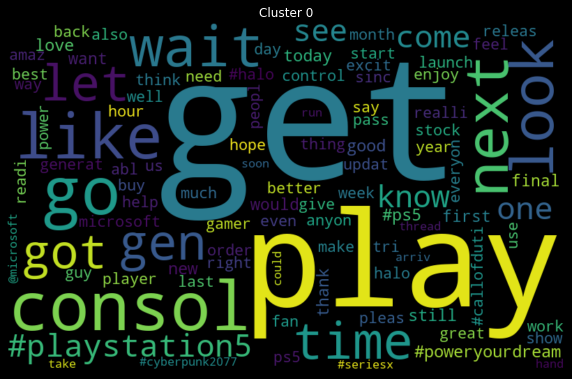

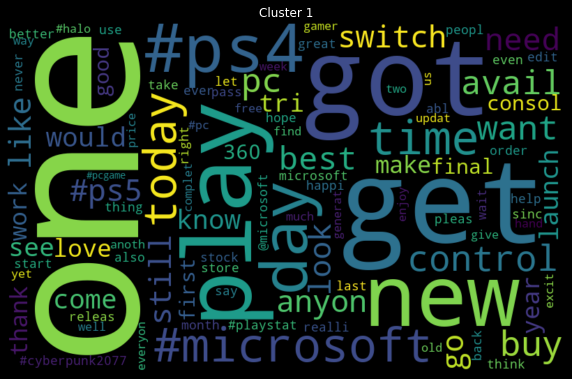

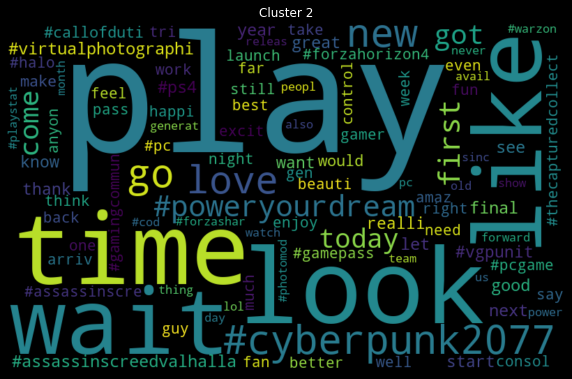

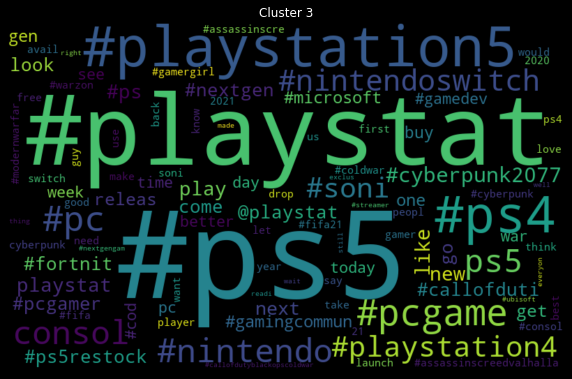

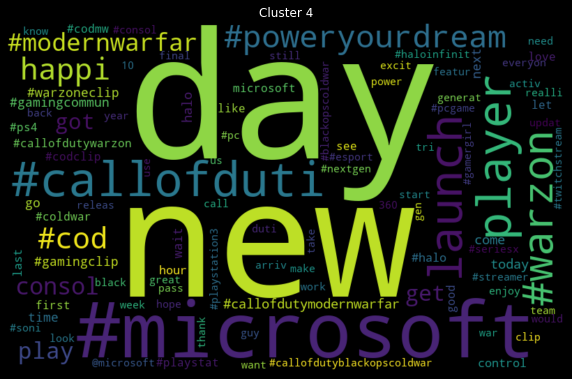

In [17]:
def clusters_wordcloud(centroids,vec, model, type_model):
  # Creating the dictionary that must be given as input to wordcount 
  # using the info provided by centroids (term indices and tfidf)
  word_freq = dict()
  centroids_indices = centroids.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
  terms = vec.get_feature_names()
  for i in range(model.n_clusters if type_model == 'KM' else len(model.means_)):
    word_freq[i]={}
    for ind in centroids_indices[i]:
      word_freq[i][terms[ind]] = centroids[i][ind]
  
  # Plotting the words using wordcount
  if type_model == 'KM':
    for i in range(model.n_clusters):
      try:
        wordcloud = WordCloud(background_color="black", max_words=100, width=800, height=500).generate_from_frequencies(word_freq[i])
      except:
        wordcloud = WordCloud(background_color="black", max_words=30, width=800, height=500).generate_from_frequencies(word_freq[i])
      plt.figure(figsize=(10,10))
      title = "Cluster " + str(i)
      plt.title(title)
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()
      print("\n")
  else:
    for i in range(len(model.means_)):
      wordcloud = WordCloud(background_color="black", max_words=100, 
                            width=800, height=500).generate_from_frequencies(word_freq[i])
      plt.figure(figsize=(10,10))
      title = "Cluster " + str(i)
      plt.title(title)
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()
      print("\n")

if model_clusters == 'KM': clusters_wordcloud(original_centroids, vec, model, model_clusters)
else: clusters_wordcloud(svd_means, vec, model, model_clusters)

### `Countplot` of tweet timeseries for each cluster

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


<Figure size 432x288 with 0 Axes>

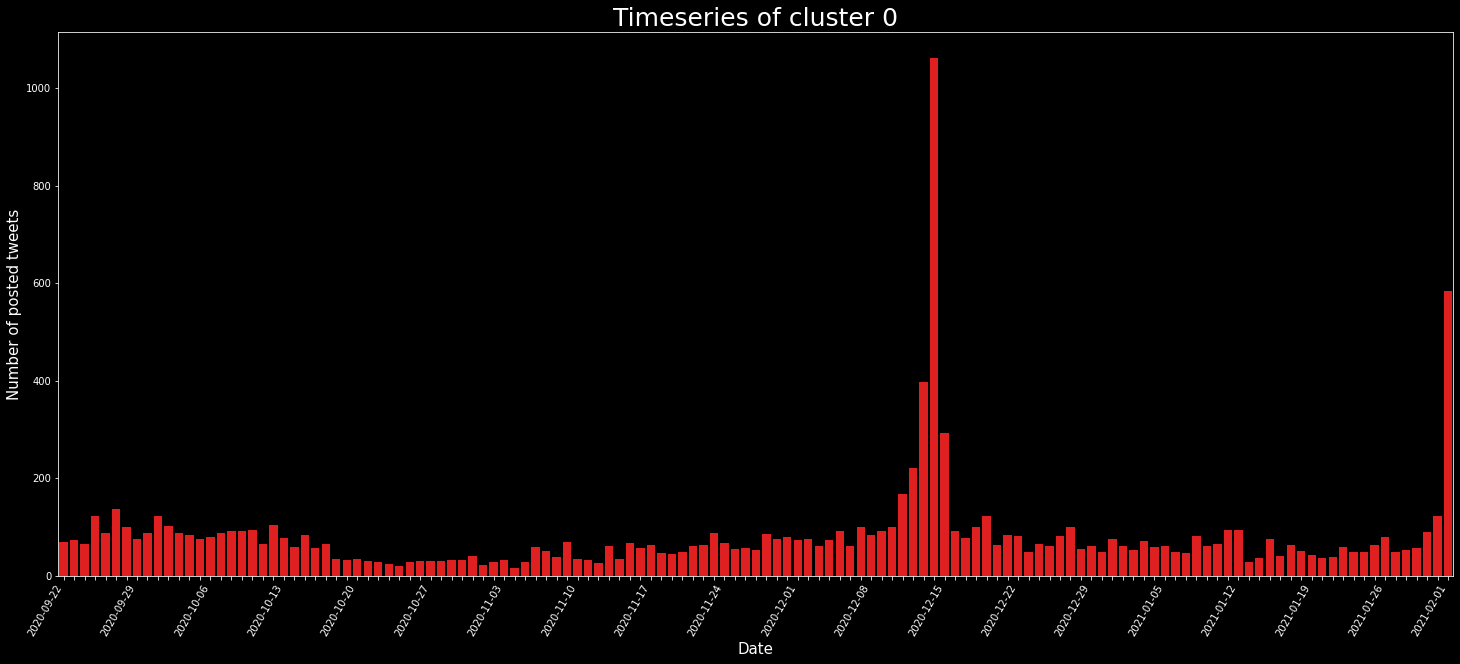

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


<Figure size 432x288 with 0 Axes>

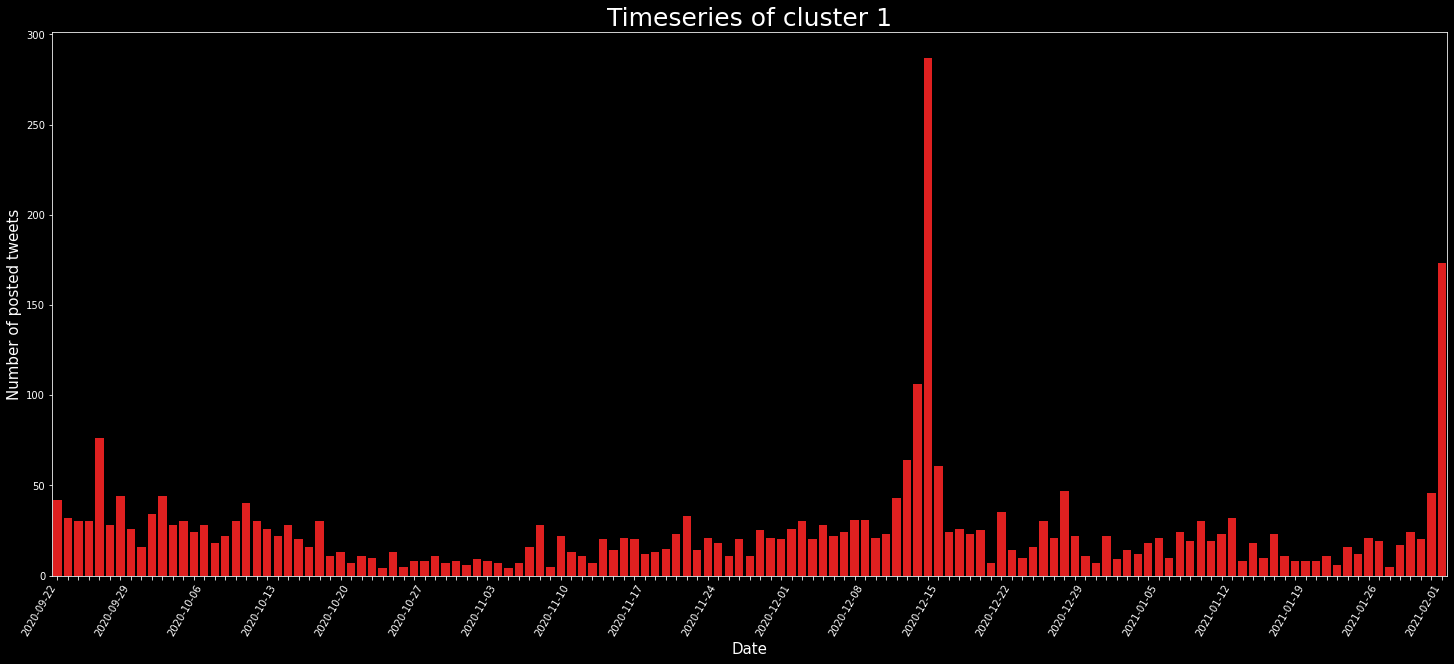

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


<Figure size 432x288 with 0 Axes>

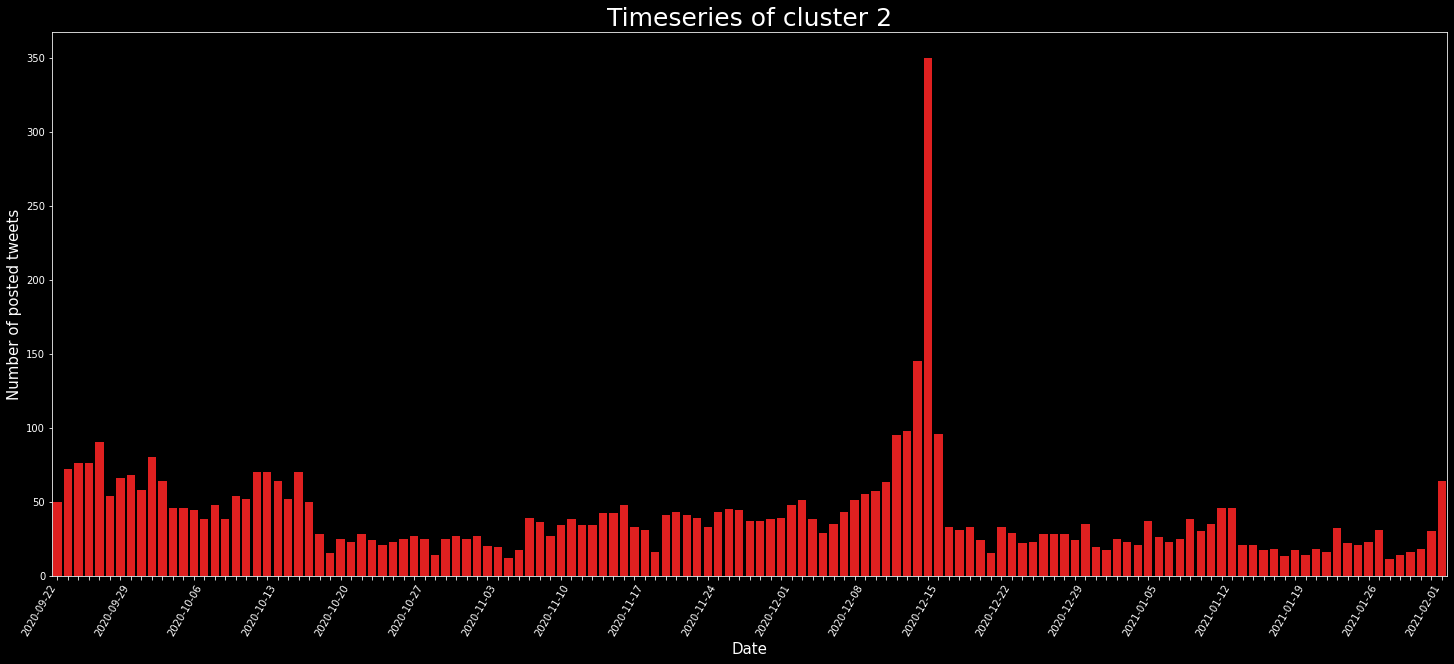

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


<Figure size 432x288 with 0 Axes>

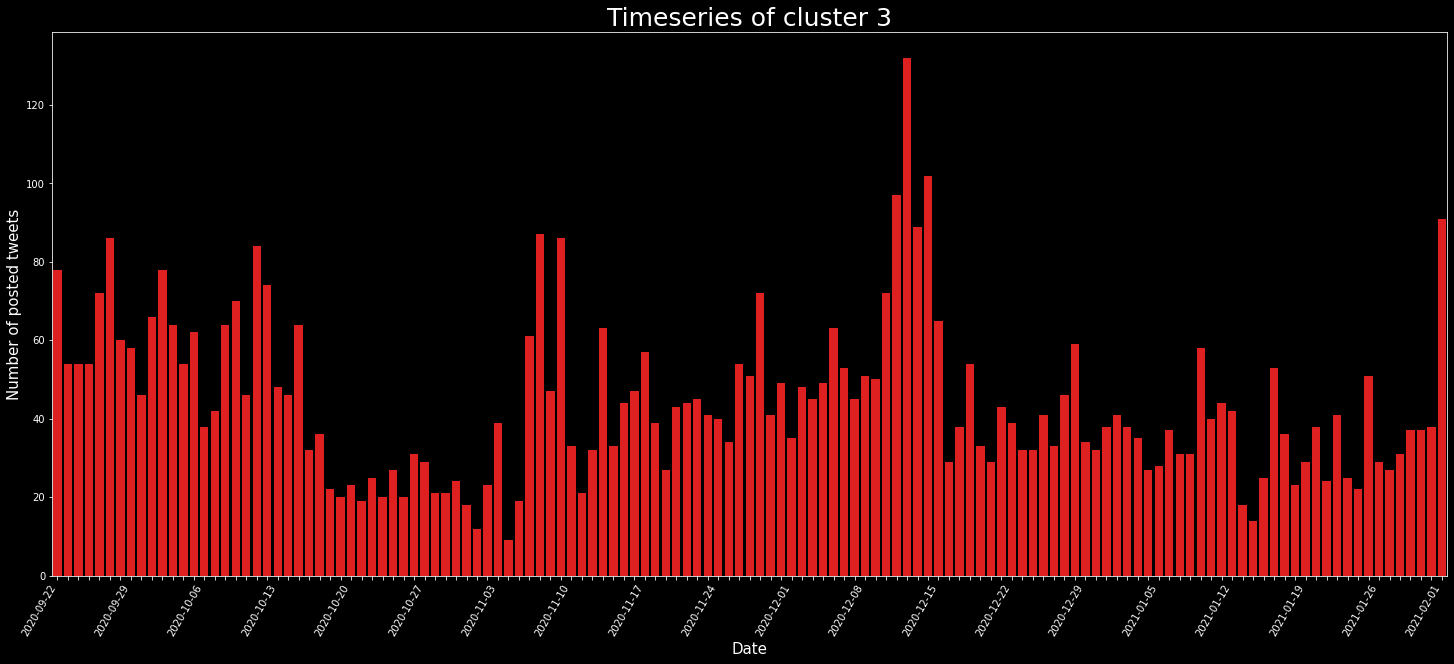

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


<Figure size 432x288 with 0 Axes>

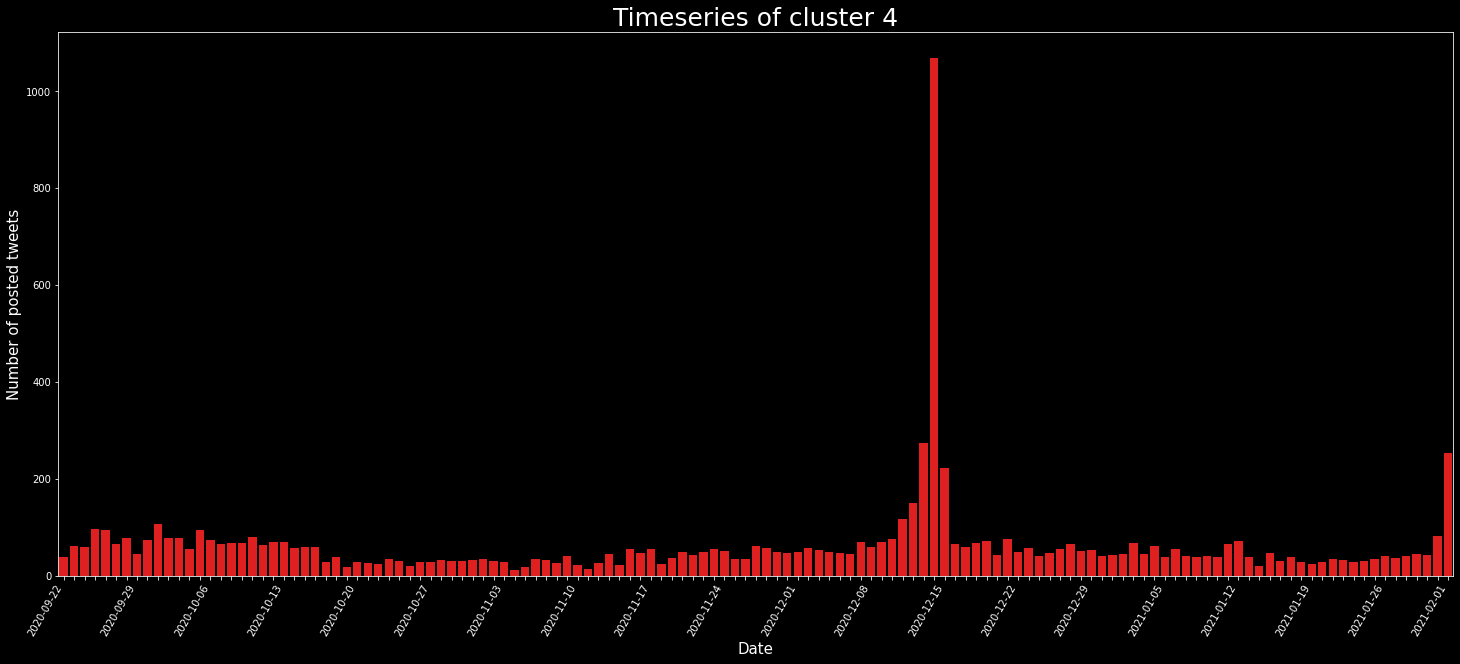

In [18]:
cl = t_df.groupby('cluster')['cluster','datatime']

CLUSTER_ID = 3
for i in range(selected_clusters):
  cl = t_df.groupby('cluster')['cluster','datatime']
  plt.figure()
  plt.style.use('dark_background')
  fig, ax = plt.subplots(figsize=(25,10))
  cl = cl.get_group(i)
  cl.datatime = cl.datatime.apply(lambda x: str(x)).apply(lambda x: (x[-2:]+'-'+x[4:6]+'-'+x[0:4]))
  cl.datatime = pd.to_datetime(cl.datatime, format = "%d-%m-%Y")

  fig = sns.countplot(x='datatime', data=cl, color='red')
  plt.title('Timeseries of cluster '+str(i), fontsize=25)
  plt.xlabel("Date", fontsize=15)
  plt.ylabel("Number of posted tweets", fontsize=15)
  x_dates = cl['datatime'].sort_values().unique()
  tick_dates = []
  counter = 0
  for i in range(len(x_dates)-1):
      if i%7 == 0:
          tick_dates.append(str(x_dates[i])[:10])
      else:
          tick_dates.append(None)
  tick_dates.append(str(x_dates[len(x_dates)-1])[:10])
  ax.set_xticklabels(labels=tick_dates, rotation=60, ha='right')
  plt.show()

### Getting nearest tweets to each centroid

In [19]:
if model_clusters == 'KM':
  closest, _ = pairwise_distances_argmin_min(model.cluster_centers_, X_svd)
  for i in range(len(closest)):
    if using_hashtag: print("CLUSTER ",i, " >> ", t_df['full_text'].iloc[closest[i]]) 
    else: print("CLUSTER ",i, " >> ", t_df['full_text_wout_hashtag'].iloc[closest[i]]) 

CLUSTER  0  >>  i expect anyth less point hater gonna hate       11 2020we believ say pleas blow vape smoke  seri thread
CLUSTER  1  >>  one full year complet @microsoft reward my   make room  i come   #microsoftreward   
CLUSTER  2  >>  i much love #fabl seri i play fabl 3 mani time friend use walkthrough guid gotta love game  #nextgen #pcgame    anz  27 2020to 10 year make mark albion happi birthday @fabl @fabl iii
CLUSTER  3  >>  triumph achiev iron steel power greatest triumph find soon kingdom sieg come autumn 2021 #gamedev #indiedev #indiegam #videogam #rpg #game  #ps5 #playstat  #unrealengin #madewithunr
CLUSTER  4  >>  spacebas startopia preview welcom ultim space resort   


## Cluster sentiment

In [20]:
for i in range(selected_clusters):
  total = t_df.loc[t_df['cluster'] == i]
  neg = total.groupby('sentiment analysis')['sentiment analysis'].count()[-1] / len(total)
  neu = total.groupby('sentiment analysis')['sentiment analysis'].count()[0] / len(total)
  pos = total.groupby('sentiment analysis')['sentiment analysis'].count()[1] / len(total)
  print('CLUSTER ',i)
  print('  Positive samples: ', np.round(pos*100,2),'%')
  print('  Neutral samples: ', np.round(neu*100,2),'%')
  print('  Negative samples: ', np.round(neg*100,2),'%')

CLUSTER  0
  Positive samples:  46.48 %
  Neutral samples:  11.82 %
  Negative samples:  41.7 %
CLUSTER  1
  Positive samples:  42.08 %
  Neutral samples:  13.38 %
  Negative samples:  44.55 %
CLUSTER  2
  Positive samples:  54.6 %
  Neutral samples:  8.14 %
  Negative samples:  37.26 %
CLUSTER  3
  Positive samples:  34.03 %
  Neutral samples:  14.95 %
  Negative samples:  51.02 %
CLUSTER  4
  Positive samples:  37.61 %
  Neutral samples:  7.4 %
  Negative samples:  54.99 %


## Applying LDA on clusters



 ---------- CLUSTER # 0  ----------


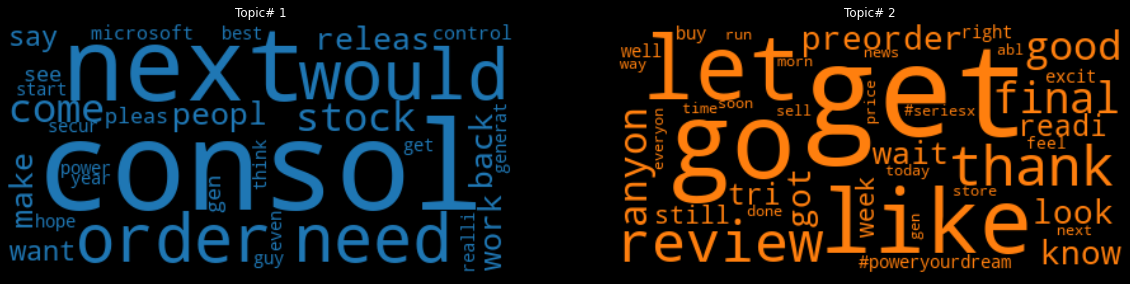



 ---------- CLUSTER # 1  ----------


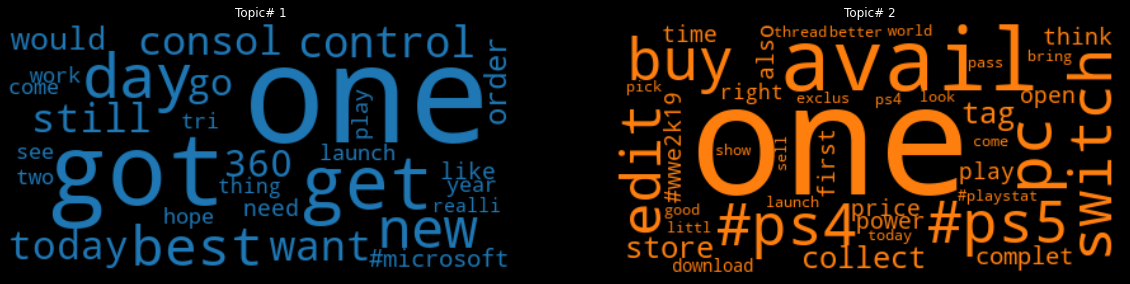



 ---------- CLUSTER # 2  ----------


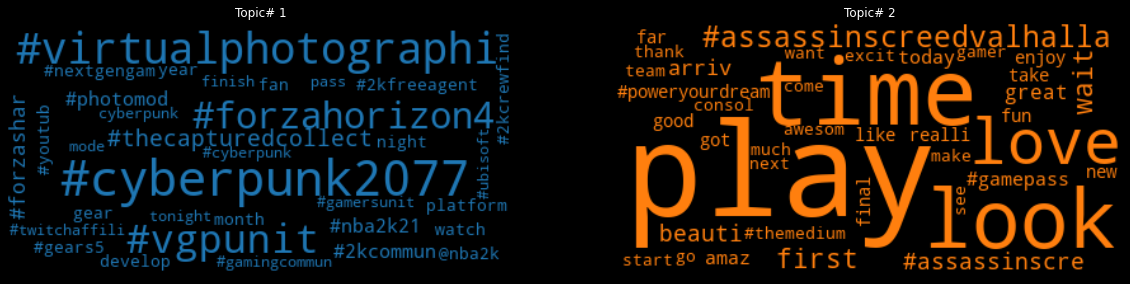



 ---------- CLUSTER # 3  ----------


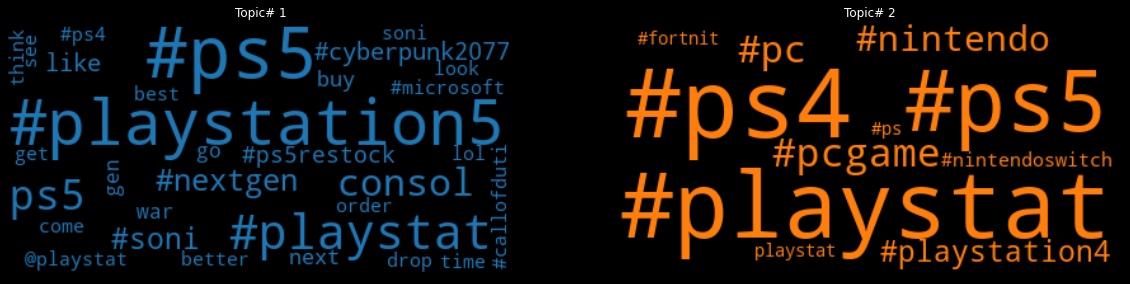



 ---------- CLUSTER # 4  ----------


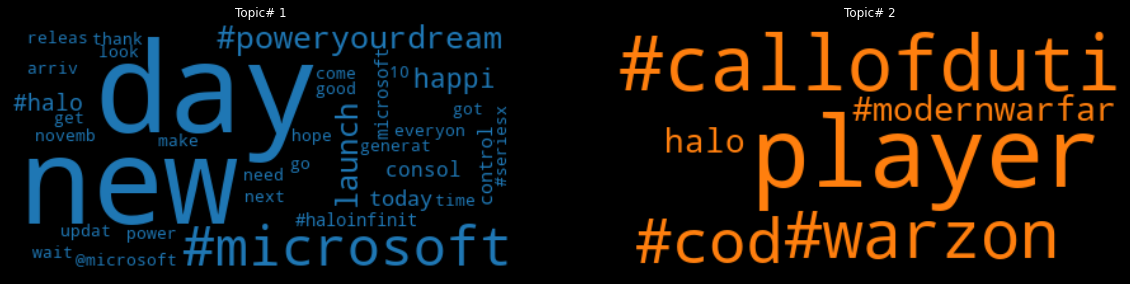

In [21]:
def topics_wordcloud(lda_model, n_top_words):
  cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
  terms_count = n_top_words
  fig, axs = plt.subplots(1, len(lda_model.components_), figsize=(20,25))

  for idx,topic in enumerate(lda_model.components_):
    #print('Topic# ',idx+1)
    abs_topic = abs(topic)
    topic_terms = [[terms[i],topic[i]] for i in abs_topic.argsort()[:-terms_count-1:-1]]
    topic_terms_sorted = [[terms[i], topic[i]] for i in abs_topic.argsort()[:-terms_count - 1:-1]]
    topic_words = []
    for i in range(terms_count):
      topic_words.append(topic_terms_sorted[i][0])
    dict_word_frequency = {}
    for i in range(terms_count):
      dict_word_frequency[topic_terms_sorted[i][0]] = topic_terms_sorted[i][1]
      wcloud = WordCloud(background_color="black",mask=None, max_words=100,\
                         contour_width=3, contour_color='black', colormap='tab10', 
                         min_font_size=12, color_func=lambda *args, **kwargs: cols[idx])
    wcloud.generate_from_frequencies(dict_word_frequency)
    axs[idx].imshow(wcloud, interpolation='bilinear')
    axs[idx].axis("off")
    axs[idx].set_title('Topic# '+ str(idx+1))
  plt.show()

##  This function filters from X_vec (vectorized full dataset) just the vectors belonging to a certain cluster
#   This is useful to apply LDA to single clusters, instead of picking the full dataset, for CLUSTER-SPECIFIC LOCAL TOPICS
def get_cluster_vectors(cluster_id, X_vec, labels):
  idx = [i for i in np.where(labels == cluster_id)] #select indices of the dataset, having that cluster_id
  X_cluster = [X_vec[i] for i in idx]
  return X_cluster[0]

##  This function is used to extract topics for each cluster using Latent Dirichelet Allocation algorithm
def extract_local_topics(model, X, n_topics, n_top_words,  labels, which_model = 'KM'):
  if which_model == 'GMM': num_clust = len(model.means_)
  else: num_clust = model.n_clusters
  for cluster_id in range(num_clust):
    print("\n\n ---------- CLUSTER #", cluster_id, " ----------")

    X_cluster = get_cluster_vectors(cluster_id, X, labels)
    lda = LatentDirichletAllocation(n_components=n_topics, max_iter=5, learning_method='online', 
                                    learning_offset=50.,random_state=SEED).fit(X_cluster)

    topics_wordcloud(lda, n_top_words)

extract_local_topics(model, X, N_TOPICS, N_TOP_WORDS, t_df['cluster'], model_clusters)

## Hierarchical clustering

The following `dendrogram` shows the hierarchical relationship between tweets. The main use of it is to work out the best way to allocate objects to clusters. The key to interpreting a dendrogram is to focus on the height at which any two objects are joined together. Infact, objects that join together sooner (leaves) are more similar to each other than those that join together later.

In [ ]:
def plot_dendrogram(linkage_matrix):
  plt.figure(figsize=(60,30))
  dendrogram = hierarchy.dendrogram(linkage_matrix,  orientation="top", 
                                    leaf_font_size=9, leaf_rotation=360)
  plt.ylabel('Euclidean Distance', fontsize=20);
  plt.xlabel("Cluster size", fontsize=20)
  plt.title("Hierarchical clustering dendogram", fontsize=26)
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)

def plot_dendrogram_truncated(linkage_matrix):
  st = time.time()
  plt.figure(figsize=(40,20))
  dendrogram = hierarchy.dendrogram(linkage_matrix,  orientation="top", 
                                    show_contracted=True, truncate_mode='lastp', # plot just the first part of the graph (more distinct groups)
                                    leaf_font_size=12, leaf_rotation=90.)

  plt.ylabel('Euclidean Distance', fontsize=20);
  plt.xlabel("Cluster size", fontsize=20)
  plt.title("Hierarchical clustering dendogram (truncated)", fontsize=26)
  plt.xticks(fontsize=18)
  plt.yticks(fontsize=18)
  plt.show()
  
  elapsed_time = time.time() - st
  print("Plotted in ",elapsed_time, " seconds.")

sys.setrecursionlimit(10000) #otherwise you get errors

st = time.time()
linkage_matrix = hierarchy.linkage(X_svd, method="complete")
elapsed_time = time.time() - st
print("Agglomerative clustering ended in ",elapsed_time, " seconds.")

st = time.time()
plot_dendrogram(linkage_matrix)
elapsed_time = time.time() - st
print("Plotted in ",elapsed_time, " seconds.")

plot_dendrogram_truncated(linkage_matrix)

Agglomerative clustering ended in  50.68288612365723  seconds.
Plotted in  32.28420400619507  seconds.
